<a href="https://colab.research.google.com/github/morgan03153/game/blob/master/morgan_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install yfinance pandas numpy scikit-learn keras google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client google-cloud-storage


畫曲線圖

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas_datareader.data as web

# 設定時間範圍
end_date = datetime.today()
start_date = end_date - timedelta(days=60)

# 獲取1個月期美國國債殖利率
treasury_1mo = web.DataReader('DGS1MO', 'fred', start_date, end_date)

# 獲取其他數據
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 合併數據以便於繪圖
combined_data = pd.DataFrame({
    '1-Month Treasury Yield': treasury_1mo['DGS1MO'],
    'VIX': vix_data['Close'],
    'VOO': voo_data['Close'],
    'NVDA': nvda_data['Close'],
    'MSFT': msft_data['Close'],
    'AVGO': avgo_data['Close']
})

# 正規化處理，使每條曲線的第一點為100
normalized_data = combined_data.apply(lambda x: (x / x.iloc[0]) * 100)

# 定義不同的marker
markers = ['o', 'x', 's', 'D', '^', 'v']

# 繪製所有曲線在同一張圖上，並在每一點加上不同的標記
plt.figure(figsize=(14, 8))

for i, column in enumerate(normalized_data.columns):
    plt.plot(normalized_data.index, normalized_data[column], label=column, marker=markers[i])

plt.title('Normalized 1-Month Treasury Yield, VIX, and Selected Stocks (Base 100)')
plt.xlabel('Date')
plt.ylabel('Normalized Value (Base 100)')
plt.legend(loc='upper left')
plt.grid(True)

# 调整X轴日期标签为直式显示
plt.xticks(rotation=90)

plt.show()


訓練程式

In [20]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
data_days = 300        # 用于提取数据的天数
look_back = 50         # LSTM 模型的 look back 时间窗口
forward_days = 8       # 設定未来天数范围
drop_threshold = 0.88  # 設定价格下跌比例的閾值

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=data_days)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT']

# 对每个特征单独进行标准化
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[[column]])
    scalers[column] = scaler

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = np.mean(nvda_scaled[i+1:i+forward_days])
        if future_prices < current_price * drop_threshold:
            y_binary[i] = 1
    return y_binary

nvda_scaled = combined_data['NVDA'].values  # 取 NVDA 数据的缩放结果
y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

# 創建數據集
def create_dataset(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# 創建 X 和 y 數據集
X, y = create_dataset(combined_data.values, y_binary, look_back)

# 確認 X 的形狀
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 確保 X 是三維的
if len(X.shape) != 3:
    raise ValueError("X does not have the correct shape. Expected a 3D array.")

# 拆分訓練集和測試集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 顯示測試集日期範圍
test_start_date = start_date + timedelta(days=split)
test_end_date = end_date - timedelta(days=look_back)
print(f"Test period: {test_start_date.date()} to {test_end_date.date()}")

# 構建 LSTM 模型（增加一層隱藏層）
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.9))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.9))
    model.add(Dense(units=1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 訓練模型
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.1, verbose=1)

# 保存模型
model_save_path = os.path.join(save_path, 'nvda_lstm_model.h5')
model.save(model_save_path)
print(f'Model saved to: {model_save_path}')

# 模型評估
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 預測結果
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# 顯示預測結果
print(f"y_pred (binary): {y_pred_binary.flatten()}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-20-7903ff4a3c27>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-20-7903ff4a3c27>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-20-7903ff4a3c27>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-20-7903ff4a3c27>:39: FutureWarning: DataFrame.fillna wi

X shape: (156, 50, 4)
y shape: (156,)
Test period: 2024-02-17 to 2024-06-22
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.6133 - loss: 0.6683 - val_accuracy: 1.0000 - val_loss: 0.5374
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7889 - loss: 0.5759 - val_accuracy: 1.0000 - val_loss: 0.4141
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8024 - loss: 0.5135 - val_accuracy: 1.0000 - val_loss: 0.2739
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8674 - loss: 0.4410 - val_accuracy: 1.0000 - val_loss: 0.1554
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8819 - loss: 0.3558 - val_accuracy: 1.0000 - val_loss: 0.0795
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9460 - loss: 0.2426 - val_accuracy: 1.0000 - val_loss: 0.0403
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9500 - loss: 0.1851 - val_accuracy: 1.0000 - val_loss: 0.0227
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/ste

Model saved to: /content/drive/My Drive/nvda_lstm/nvda_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9375 - loss: 0.3637
Test Loss: 0.3636622428894043
Test Accuracy: 0.9375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
y_pred (binary): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-30-48873b0323eb>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-30-48873b0323eb>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-30-48873b0323eb>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-30-48873b0323eb>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj

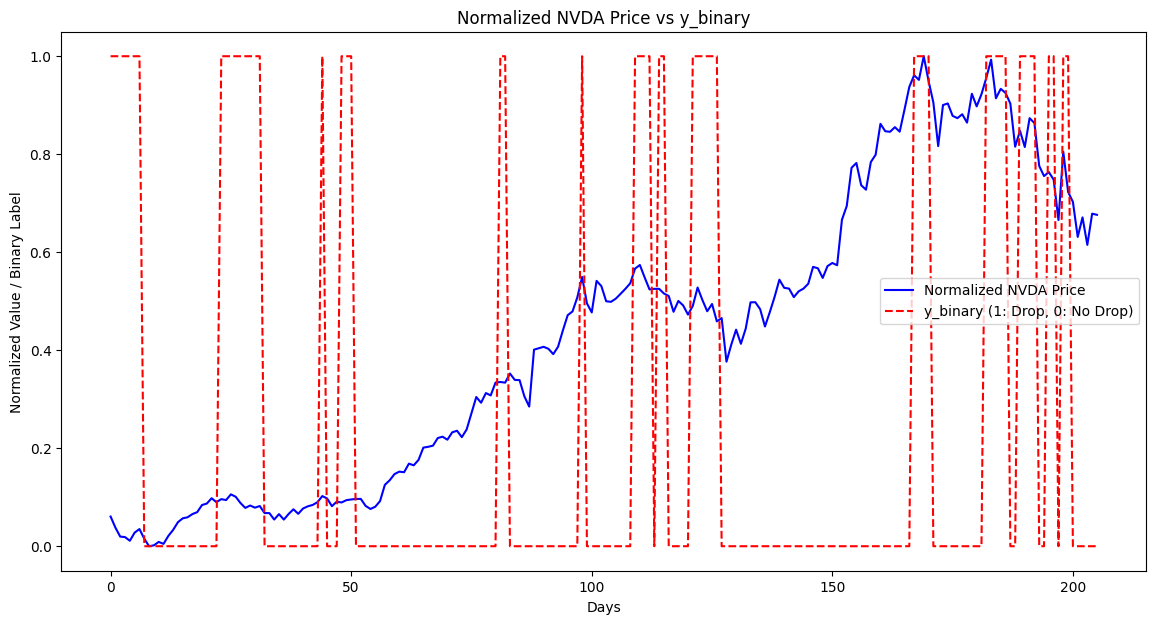

X shape: (156, 50, 4)
y shape: (156,)
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 763ms/step - accuracy: 0.5375 - loss: 0.6532 - val_accuracy: 0.5625 - val_loss: 1.0829
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.8021 - loss: 0.5546 - val_accuracy: 0.5625 - val_loss: 1.0004
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.8096 - loss: 0.5304 - val_accuracy: 0.5625 - val_loss: 0.8297
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.8221 - loss: 0.4966 - val_accuracy: 0.5625 - val_loss: 0.8587
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.8071 - loss: 0.4994 - val_accuracy: 0.5625 - val_loss: 0.8993
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.8221 - loss: 0.4774 - val_accuracy: 0.5625 - val_loss: 0.8255
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.7696 - loss: 0.5616 - val_accuracy: 0.5625 - val_loss: 0.7200
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.8171 - loss: 0.4828 - val_accuracy: 0.5625 - val_loss: 0.8217
Epo

Model saved to: /content/drive/My Drive/nvda_lstm/nvda_lstm_model.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8572 - loss: 0.3918
Training Loss: 0.4649277627468109
Training Accuracy: 0.8269230723381042


In [30]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
data_days = 300        # 用于提取数据的天数
look_back = 50         # LSTM 模型的 look back 时间窗口
forward_days = 5       # 設定未来天数范围
drop_threshold = 0.95  # 設定价格下跌比例的閾值

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=data_days)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT']

# 对每个特征单独进行标准化
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[[column]])
    scalers[column] = scaler

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = nvda_scaled[i+forward_days]
        if future_prices < current_price * drop_threshold:
            y_binary[i] = 1
    return y_binary

# 創建 y_binary 和 nvda_scaled 曲線圖
nvda_scaled = combined_data['NVDA'].values  # 取 NVDA 数据的缩放结果
y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

plt.figure(figsize=(14, 7))
plt.plot(nvda_scaled, color='blue', label='Normalized NVDA Price')
plt.plot(y_binary, color='red', linestyle='--', label='y_binary (1: Drop, 0: No Drop)')
plt.title('Normalized NVDA Price vs y_binary')
plt.xlabel('Days')
plt.ylabel('Normalized Value / Binary Label')
plt.legend()
plt.show()

# 創建數據集
def create_dataset(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# 創建 X 和 y 數據集
X, y = create_dataset(combined_data.values, y_binary, look_back)

# 確認 X 的形狀
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 確保 X 是三維的
if len(X.shape) != 3:
    raise ValueError("X does not have the correct shape. Expected a 3D array.")

# 構建 LSTM 模型
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=150, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
model.fit(X, y, epochs=20, batch_size=50, validation_split=0.1, verbose=1)

# 保存模型
model_save_path = os.path.join(save_path, 'nvda_lstm_model.h5')
model.save(model_save_path)
print(f'Model saved to: {model_save_path}')

# 模型評估
loss, accuracy = model.evaluate(X, y)
print(f'Training Loss: {loss}')
print(f'Training Accuracy: {accuracy}')

# 創建檢查內層輸出值的模型
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[0].output)  # 输出第一个LSTM层的结果

# 測試內層輸出值
#intermediate_output = intermediate_layer_model.predict(X)
#print("Intermediate output shape:", intermediate_output.shape)
#print("Sample intermediate output for first sequence:", intermediate_output[0])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-32-34af8ec471a3>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-32-34af8ec471a3>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-32-34af8ec471a3>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-32-34af8ec471a3>:37: FutureWarning: DataFrame.fillna wi

X shape: (170, 50, 4)
y shape: (170,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

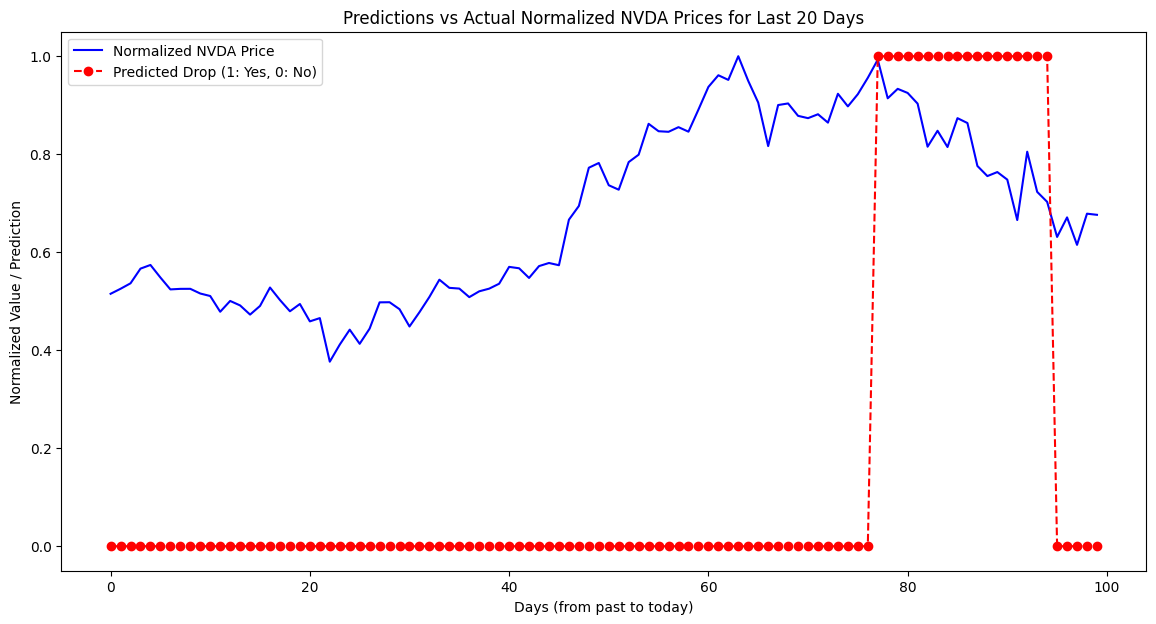

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Today's Prediction (Binary): 0


In [32]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import load_model

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
data_days = 320        # 用于提取数据的天数
look_back = 50         # LSTM 模型的 look back 时间窗口


# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=data_days)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT']

# 对每个特征单独进行标准化
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[[column]])
    scalers[column] = scaler

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = np.mean(nvda_scaled[i+1:i+forward_days])
        if future_prices < current_price * drop_threshold:
            y_binary[i] = 1
    return y_binary

# 創建數據集
#nvda_scaled = combined_data['NVDA'].values
#y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

def create_dataset(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# 創建 X 和 y 數據集
X, y = create_dataset(combined_data.values, y_binary, look_back)

# 確認 X 的形狀
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 確保 X 是三維的
if len(X.shape) != 3:
    raise ValueError("X does not have the correct shape. Expected a 3D array.")

# 加载模型
model = load_model(os.path.join(save_path, 'nvda_lstm_model.h5'))

# 保存過去20天的預測結果
predictions_binary = []
actual_prices = []

for i in range(100):
    # 从最近的历史数据中提取X进行预测
    X_input = X[-(i + 1)].reshape(1, X.shape[1], X.shape[2])
    y_pred = model.predict(X_input)
    y_pred_binary = (y_pred > 0.5).astype(int)
    predictions_binary.append(y_pred_binary[0][0])

    # 保存相应的实际价格
    actual_prices.append(nvda_scaled[-(i + 1)])

# 逆序，使日期從過去到現在
predictions_binary.reverse()
actual_prices.reverse()

# 繪製實際價格（正規化後）和預測結果
plt.figure(figsize=(14, 7))
plt.plot(range(100), actual_prices, color='blue', label='Normalized NVDA Price')
plt.plot(range(100), predictions_binary, color='red', linestyle='--', marker='o', label='Predicted Drop (1: Yes, 0: No)')
plt.title('Predictions vs Actual Normalized NVDA Prices for Last 20 Days')
plt.xlabel('Days (from past to today)')
plt.ylabel('Normalized Value / Prediction')
plt.legend()
plt.show()

# 推論基於今天的結果
X_today = X[-1].reshape(1, X.shape[1], X.shape[2])
y_pred_today = model.predict(X_today)
y_pred_today_binary = (y_pred_today > 0.5).astype(int)

# 顯示今天的推論結果
print(f"Today's Prediction (Binary): {y_pred_today_binary[0][0]}")
